# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook:
1. Get probe template
2. Get the Bragg disks
3. **Calibrate**
4. Calculate lattice vectors
5. Fit lattice vectors
6. Calculate strain
7. Visualize strain maps

# Notebook 3a: Calibrate diffraction shifts

In this step, we measure and correct the relative shifts of the diffraction patterns due to the scanning of the beam. For small field-of-view scans, this step may not be necessary.

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse
from time import time
from scipy.ndimage.filters import gaussian_filter

from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import FileBrowser, read, append

# i/o
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import FileBrowser, read, append

# Diffraction shift correction
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.process.calibration import get_diffraction_shifts, find_outlier_shifts, shift_braggpeaks
from py4DSTEM.process.fit import fit_2D
from py4DSTEM.process.braggdiskdetection import get_bragg_vector_map

In [2]:
# Examine file contents

fp_pr = "/home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/Al_STD_300mm_processing.h5"
browser = FileBrowser(fp_pr)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    braggvectormap_uncorrected          DiffractionSlice    
   2    probe                               DiffractionSlice    
   3    braggpeaks                          PointListArray      


In [3]:
# Load data

braggpeaks_uncorrected = browser.get_dataobject('braggpeaks')
braggvectormap_uncorrected = browser.get_dataobject('braggvectormap_uncorrected').data2D
browser.close()

In [4]:
R_Nx,R_Ny = braggpeaks_uncorrected.shape
Q_Nx,Q_Ny = braggvectormap_uncorrected.shape

### 1. Diffraction shifts

Here we measure and correct shifts of the diffraction patterns due to the scanning of the beam in real space.  We proceed as follows:

Measure diffraction shifts
- Get an initial guess at the diffraction shifts
- Find outliers in initial diffraction shift guesses
- Ignoring outliers, fit a plane or parabola to the initial guess.

Correct diffraction shifts
- Apply shifts to the Bragg peak positions

#### Measure diffraction shifts

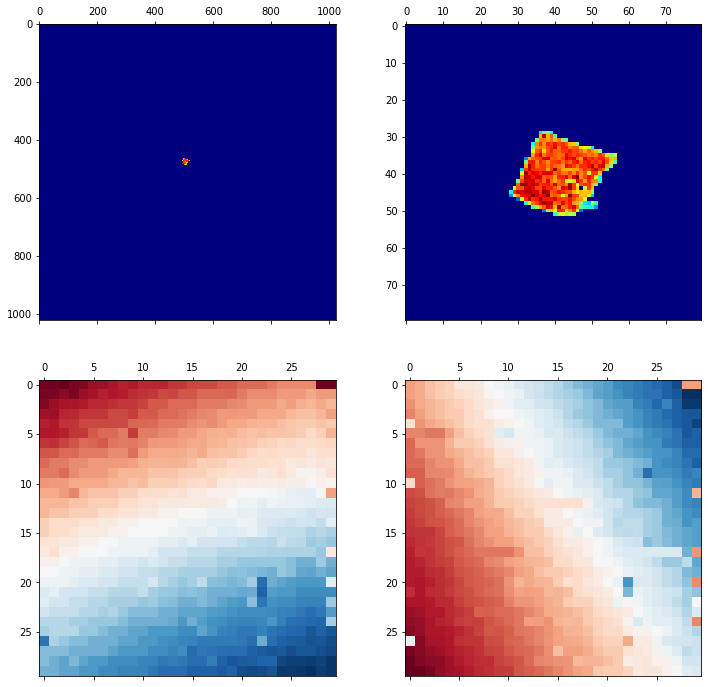

In [5]:
# Get diffraction shifts

findcenter = 'CoM'   # Must be 'CoM' or 'max'
rad = 40             # for display
power = 0.25

xshifts, yshifts, braggvectormap_center = get_diffraction_shifts(braggpeaks_uncorrected,
                                                                 Q_Nx, Q_Ny,
                                                                 findcenter=findcenter)

# Show
x0,y0 = py4DSTEM.process.utils.get_CoM(braggvectormap_center)

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(braggvectormap_center**0.25,cmap='jet')
ax12.matshow(braggvectormap_center[int(x0-rad):int(x0+rad),int(y0-rad):int(y0+rad)]**power,cmap='jet')
ax21.matshow(xshifts,cmap="RdBu")
ax22.matshow(yshifts,cmap="RdBu")
plt.show()

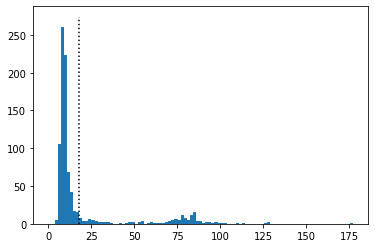

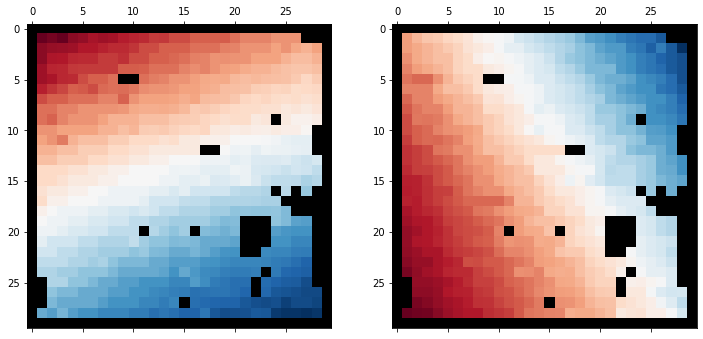

In [6]:
# Find outliers

n_sigma = 10
edge_boundary = 1
n_bins = 100

mask,n,bins,cutoff = find_outlier_shifts(xshifts,yshifts,n_sigma=n_sigma,edge_boundary=edge_boundary,n_bins=n_bins)

# Show
xshifts_masked = np.ma.masked_array(xshifts, mask)
yshifts_masked = np.ma.masked_array(yshifts, mask)
mask_display = np.ma.masked_array(mask, mask==False)

fig,ax = plt.subplots()
ax.bar(bins[:-1]+(bins[1]-bins[0])/2., n, (bins[1]-bins[0]), align='center')
ax.vlines(cutoff,0,ax.get_ylim()[1],linestyle=':')
plt.show()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(xshifts_masked,cmap="RdBu")
ax2.matshow(yshifts_masked,cmap="RdBu")
ax1.matshow(mask_display)
ax2.matshow(mask_display)
plt.show()

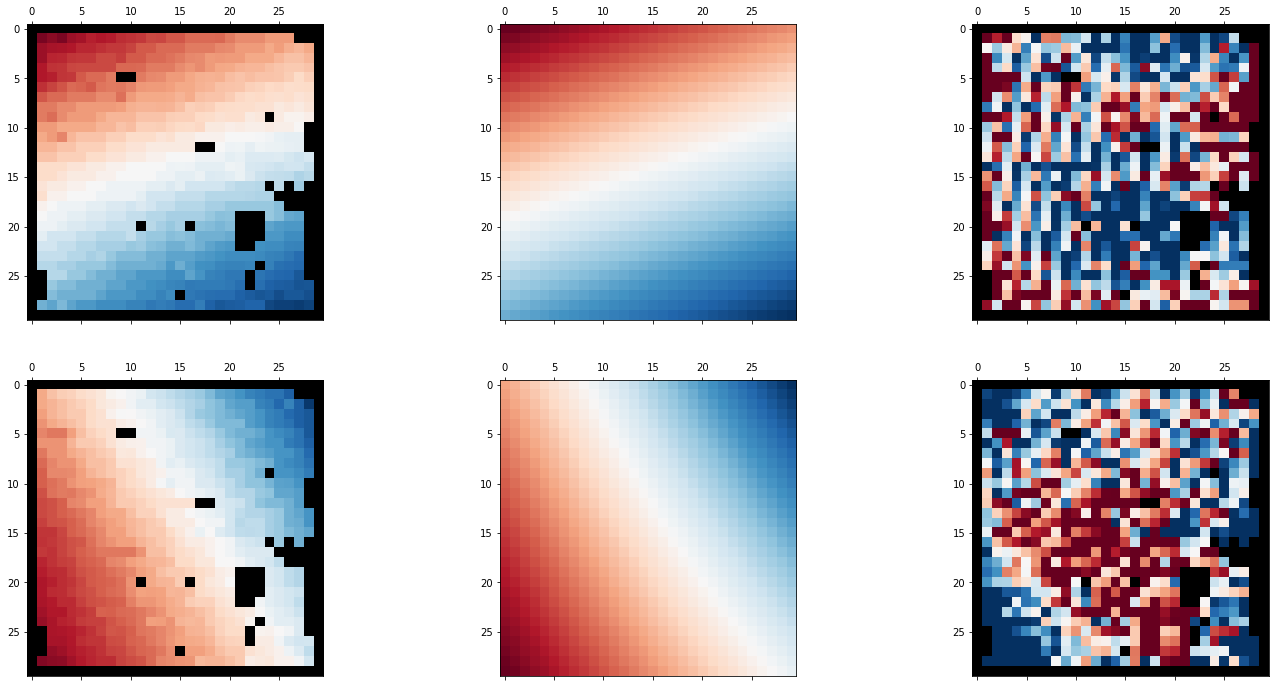

In [7]:
# Fit the diffraction shifts

#fit_function = py4DSTEM.process.fit.plane        # Select fit type
fit_function = py4DSTEM.process.fit.parabola

# Fit
xshifts_fit = np.zeros_like(xshifts)
yshifts_fit = np.zeros_like(yshifts)
popt_x, pcov_x, xshifts_fit = fit_2D(fit_function, xshifts, data_mask=mask==False)
popt_y, pcov_y, yshifts_fit = fit_2D(fit_function, yshifts, data_mask=mask==False)
residuals_x = xshifts-xshifts_fit
residuals_y = yshifts-yshifts_fit
residuals_x[mask] = 0
residuals_y[mask] = 0

# Show
fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,12))
ax11.matshow(xshifts,cmap="RdBu")
ax21.matshow(yshifts,cmap="RdBu")
ax12.matshow(xshifts_fit,cmap="RdBu")
ax22.matshow(yshifts_fit,cmap="RdBu")
ax13.matshow(residuals_x,cmap="RdBu",vmin=np.median(residuals_x)-np.std(residuals_x),vmax=np.median(residuals_x)+np.std(residuals_x))
ax23.matshow(residuals_y,cmap="RdBu",vmin=np.median(residuals_y)-np.std(residuals_y),vmax=np.median(residuals_y)+np.std(residuals_y))
ax11.matshow(mask_display)
ax21.matshow(mask_display)
ax13.matshow(mask_display)
ax23.matshow(mask_display)
plt.show()

#### Correct diffraction shifts

In [8]:
# Apply shifts

braggpeaks_shiftcorrected = shift_braggpeaks(braggpeaks_uncorrected, xshifts_fit, yshifts_fit)

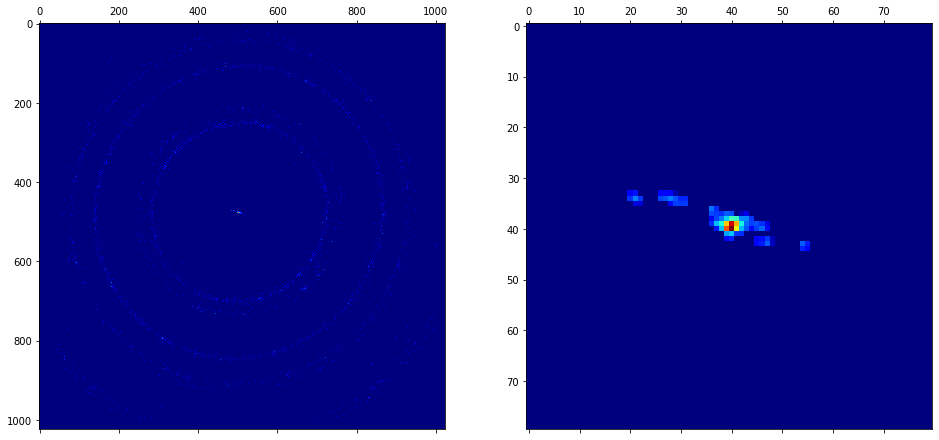

In [9]:
# Re-calculate Bragg vector map and show

braggvectormap_shiftcorrected = get_bragg_vector_map(braggpeaks_shiftcorrected,Q_Nx,Q_Ny)
power = 0.25

# Show
x0,y0=np.unravel_index(np.argmax(gaussian_filter(braggvectormap_shiftcorrected,2)),(Q_Nx,Q_Ny))
x0,y0=int(x0),int(y0)
rad=40

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(braggvectormap_shiftcorrected**0.25,cmap='jet')
ax2.matshow(braggvectormap_shiftcorrected[x0-rad:x0+rad,y0-rad:y0+rad]**power,cmap='jet')
plt.show()

### Save

In [10]:
# Store relevant data in  DataObjects

# Diffraction shifts
data = np.zeros((R_Nx,R_Ny,2))
data[:,:,0] = xshifts_fit
data[:,:,1] = yshifts_fit
diffractionshifts = RealSlice(data, slicelabels=('x_shifts','y_shifts'), name='diffraction_shifts')

# Corrected Bragg vector map
braggvectormap_diffslice = DiffractionSlice(braggvectormap_shiftcorrected, name='braggvectormap_shiftcorrected')

In [11]:
# Append to processing file

dataobjects = [diffractionshifts, braggvectormap_diffslice, braggpeaks_shiftcorrected]

append(dataobjects, fp_pr)

Opening file /home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/Al_STD_300mm_processing.h5...
Done.
